In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
data=pd.read_csv('train.csv', encoding = 'unicode_escape')

In [3]:
data.head(5)

,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT,Patient_Tag
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,6/15/2016,13:58:00,6/15/2016 23:28,Epstein,I don't disagree with you in principle. I'm ju...,0
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,5/7/2016,0.820833333,42498.21667,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,4/14/2016,15:00:38,4/15/2016 0:30,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,6/18/2016,20:46:00,6/19/2016 6:16,Bulaemia,I am 17 and I have been throwing up for about ...,1
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,6/15/2016,3:26:00,6/15/2016 12:56,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0


In [4]:
import tensorflow as tf
print(tf.version.VERSION)

2.7.0


In [5]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 30.34 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [8]:
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [7]:
!pip install sentencepiece
!pip install tensorflow_addons

     |████████████████████████████████| 1.2 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [9]:
from sklearn.model_selection import train_test_split
data.shape

(1157, 9)

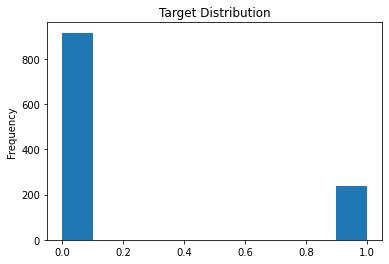

In [10]:
data.Patient_Tag.plot(kind="hist", title= "Target Distribution")

In [11]:
train_df, remaining = train_test_split(data, random_state=42, train_size=0.80, stratify=data.Patient_Tag.values)
validate_df, _  =train_test_split(remaining, random_state=42, train_size=0.80, stratify=remaining.Patient_Tag.values)
train_df.shape, validate_df.shape

((925, 9), (185, 9))

In [13]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['Link'].values, train_df['Patient_Tag'].values))
    validate_data = tf.data.Dataset.from_tensor_slices((validate_df['Link'].values, validate_df['Patient_Tag'].values))
    
    for text, label in train_data.take(1):
        print(text)
        print(label)
		
label_list = [0,1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

tf.Tensor(b'http://boards.cruisecritic.com/showthread.php?t=2349785#post49847242', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [15]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case  = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
    
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [18]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x={'input_word_ids' : input_ids, 
     'input_masks': input_mask, 
     'input_type_ids': segment_ids}

    return (x, label_id)

In [19]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  validate_data = (validate_data.map(to_feature_map, 
                                     num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
  train_data.element_spec
  validate_data.element_spec

In [20]:
def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

    model = tf.keras.Model(inputs={'input_masks': input_mask, 'input_type_ids': input_type_ids, 'input_word_ids' : input_word_ids}, outputs = output)

    return (model)

In [21]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

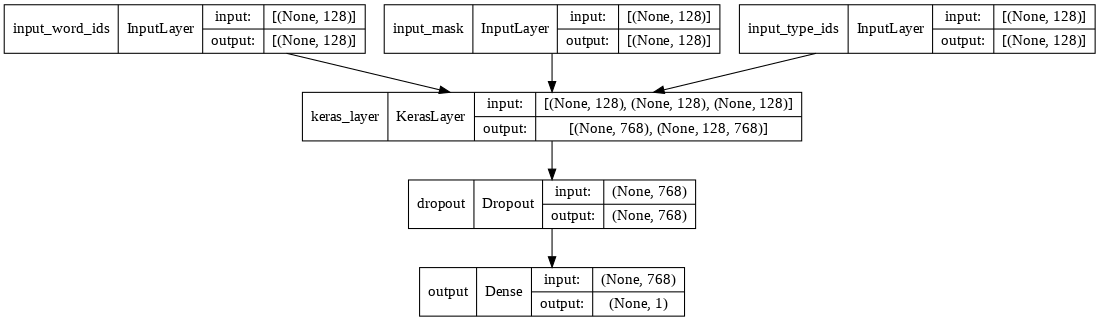

In [22]:
tf.keras.utils.plot_model(model = model, show_shapes=True, dpi=76)

In [23]:
epochs = 4
history = model.fit(train_data,
                  validation_data = validate_data, 
                  epochs=epochs,
                  verbose=1)

Epoch 1/4
28/28 [==============================] - 1322s 47s/step - loss: 0.5181 - binary_accuracy: 0.7812 - val_loss: 0.3987 - val_binary_accuracy: 0.8062
Epoch 2/4
28/28 [==============================] - 1313s 47s/step - loss: 0.4313 - binary_accuracy: 0.7757 - val_loss: 0.3448 - val_binary_accuracy: 0.8375
Epoch 3/4
28/28 [==============================] - 1317s 47s/step - loss: 0.3558 - binary_accuracy: 0.8326 - val_loss: 0.3417 - val_binary_accuracy: 0.8625
Epoch 4/4
28/28 [==============================] - 1321s 47s/step - loss: 0.2677 - binary_accuracy: 0.8728 - val_loss: 0.3718 - val_binary_accuracy: 0.8562


In [24]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

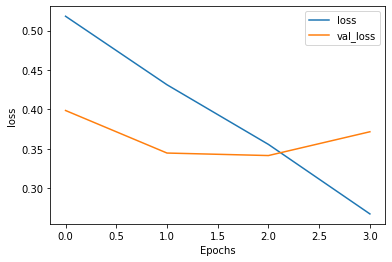

In [25]:
plot_graphs(history, 'loss')

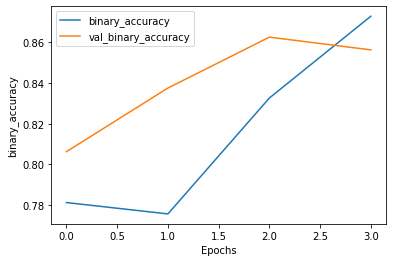

In [26]:
plot_graphs(history, 'binary_accuracy')

In [37]:
test=pd.read_csv("test.csv", encoding = 'unicode_escape')
test.head(5)

,Index,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT,Unnamed: 9
0,1,BLOG,uhmagonline.com,http://uhmagonline.com/son-of-the-late-kimbo-s...,7/30/2016,0:41:23,NaN,NaN,"Baby Slice, the son of the late Kimbo Slice, h...",NaN
1,2,FORUMS,implantinformationnetwork.yuku.com,http://implantinformationnetwork.yuku.com/topi...,6/20/2016,0:07:30,6/20/2016 9:37,My Story --,"<p><font face=""sans-serif"" size=""3"">I have had...",NaN
2,3,BLOG,http://cestlapharm.blogspot.com,http://cestlapharm.blogspot.com/2016/06/us-fda...,6/15/2016,15:44:00,6/16/2016 1:14,US FDA ?????canagliflozin?dapagliflozin?????????,"Previously, sodium-glucose cotransporter-2 (SG...",NaN
3,4,FORUMS,healthboards.com,http://www.healthboards.com/boards/heart-disor...,7/17/2016,19:41:00,NaN,NaN,Hello. I suffer from congestive heart failure ...,NaN
4,5,BLOG,http://www.sciencecodex.com,http://www.sciencecodex.com/vitamin_d_improves...,4/4/2016,15:30:45,4/5/2016 1:00,"Vitamin D improves heart function, study finds",A daily dose of vitamin D3 improves heart func...,NaN


In [35]:
test_label=pd.read_csv("sample_submission.csv", encoding = 'unicode_escape')
test_label.shape

(9, 2)

In [49]:
#with tf.device('/cpu:0'):
  #test_data = tf.data.Dataset.from_tensor_slices((test['Link'].values))
  #test_data = (test_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

test_data=tf.data.Dataset.from_tensor_slices((test['Link'], [0]*len(test['Link'])))
test_data=(test_data.map(to_feature_map).batch(1))
preds=model.predict(test_data)
#print(preds)
threshold=0.55
test['Patient_Tag']=[1 if pred>=threshold else 0 for pred in preds]

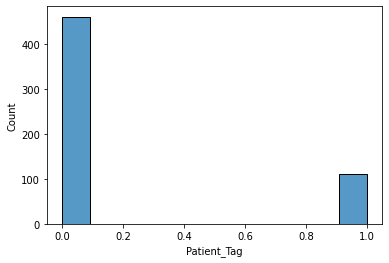

In [54]:
import seaborn as sns
sns.histplot(test['Patient_Tag'])
#print(test['Link'], test['Patient_Tag'])